# Codestral with self-correction

> Codestral is a cutting-edge generative model that has been specifically designed and optimized
for code generation tasks, including fill-in-the-middle and code completion. Codestral was trained
on 80+ programming languages, enabling it to perform well on both common and less common
languages

We can combine the code generation capabilities of Codestral the self-correction approach presented in the [AlphaCodium](https://github.com/Codium-ai/AlphaCodium) paper, [constructing an answer to a coding question iteratively](https://x.com/karpathy/status/1748043513156272416?s=20).  

We will implement some of these ideas from scratch using [LangGraph](https://python.langchain.com/docs/langgraph) to 1) produce structured code generation output from Codestral-instruct, 2) perform inline unit tests to confirm imports and code execution work, 3) feed back any errors for Codestral for self-correction.

![Screenshot 2024-05-23 at 2.17.51 PM.png](attachment:15d3ac32-cdf3-4800-a30c-f26d828d69c8.png)

In [ ]:
! pip install -U langchain_community langchain-mistralai langchain langgraph

### LLM

We'll use the Mistral API and `Codestral` instruct model, which support tool use!

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("MISTRAL_API_KEY")
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

Optionally, you can use [LangSmith](https://docs.smith.langchain.com/) for tracing.

In [ ]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "mistral-cookbook"

## Code Generation

Test with structured output.

In [ ]:
# Select LLM
from langchain_mistralai import ChatMistralAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# Mistral model
mistral_model = "codestral-latest"
llm = ChatMistralAI(model=mistral_model, temperature=0)

# Prompt
code_gen_prompt_claude = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a coding assistant. Ensure any code you provide can be executed with all required imports and variables \n
            defined. Structure your answer: 1) a prefix describing the code solution, 2) the imports, 3) the functioning code block.
            \n Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)

# Data model
class code(BaseModel):
    """Schema for code solutions to questions about LCEL."""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")

# LLM
code_gen_chain = llm.with_structured_output(code, include_raw=False)

In [ ]:
question = "Write a function for fibonacci."
messages = [("user", question)]

In [ ]:
# Test
result = code_gen_chain.invoke(messages)
result

code(prefix='A function to calculate the nth Fibonacci number.', imports='', code='def fibonacci(n):\n    if n <= 0:\n        return "Input should be positive integer"\n    elif n == 1:\n        return 0\n    elif n == 2:\n        return 1\n    else:\n        a, b = 0, 1\n        for _ in range(2, n):\n            a, b = b, a + b\n        return b')

# Graph

We build the above workflow as a graph using [LangGraph](https://langchain-ai.github.io/langgraph/).

### Graph state

The graph `state` schema contains keys that we want to:

* Pass to each node in our graph
* Optionally, modify in each node of our graph

See conceptual docs [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

In [ ]:
from typing import Annotated
from typing import Dict, TypedDict, List
from langgraph.graph.message import AnyMessage, add_messages

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: Annotated[list[AnyMessage], add_messages]
    generation: str
    iterations: int

## Graph

In [ ]:
from operator import itemgetter
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate

### Parameters
max_iterations = 3

### Nodes
def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state.get("error", "")

    # Solution
    code_solution = code_gen_chain.invoke(messages)
    messages += [
        (
            "assistant",
            f"Here is my attempt to solve the problem: {code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}

def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    prefix = code_solution.prefix
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test. Here is the error: {e}. Reflect on this error and your prior attempt to solve the problem. (1) State what you think went wrong with the prior solution and (2) try to solve this problem again. Return the FULL SOLUTION. Use the code tool to structure the output with a prefix, imports, and code block:")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        combined_code = f"{imports}\n{code}"
        # Use a shared scope for exec
        global_scope = {}
        exec(combined_code, global_scope)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}) Reflect on this error and your prior attempt to solve the problem. (1) State what you think went wrong with the prior solution and (2) try to solve this problem again. Return the FULL SOLUTION. Use the code tool to structure the output with a prefix, imports, and code block:")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }

### Conditional edges

def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate"

We'll add persistence to the graph using [a checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/).

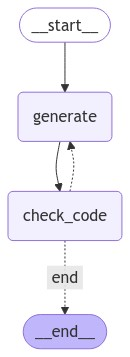

In [ ]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph

# Define the graph
builder = StateGraph(GraphState)

# Define the nodes
builder.add_node("generate", generate)  # generation solution
builder.add_node("check_code", code_check)  # check code

# Build graph
builder.set_entry_point("generate")
builder.add_edge("generate", "check_code")
builder.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "generate": "generate",
    },
)

graph = builder.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage
question = "Write a Python program that prints 'Hello, World!' to the console."
for event in graph.stream({"messages": [HumanMessage(content=question)], "iterations": 0}, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content="Write a Python program that prints 'Hello, World!' to the console.", additional_kwargs={}, response_metadata={}, id='9dd8d0c4-50f7-4b1d-8377-82e16ff0261d')], 'iterations': 0}
---GENERATING CODE SOLUTION---
{'messages': [HumanMessage(content="Write a Python program that prints 'Hello, World!' to the console.", additional_kwargs={}, response_metadata={}, id='9dd8d0c4-50f7-4b1d-8377-82e16ff0261d'), AIMessage(content="Here is my attempt to solve the problem: The task is to write a simple Python program that prints 'Hello, World!' to the console. There are no specific imports required for this task. \n Imports:  \n Code: print('Hello, World!')", additional_kwargs={}, response_metadata={}, id='4f9368ca-af4e-44c6-9473-330d8c9000ee'), AIMessage(content="Here is my attempt to solve the problem: The task is to write a simple Python program that prints 'Hello, World!' to the console. There are no specific imports required for this task. \n Imports:  \n Code: pr

`Trace:`

https://smith.langchain.com/public/a59ec940-f618-411d-adc9-1781816e7627/r

In [ ]:
question = """Create a Python program that allows two players to play a game of Tic-Tac-Toe. The game should be played on a 3x3 grid. The program should:

- Allow players to take turns to input their moves.
- Check for invalid moves (e.g., placing a marker on an already occupied space).
- Determine and announce the winner or if the game ends in a draw.

Requirements:
- Use a 2D list to represent the Tic-Tac-Toe board.
- Use functions to modularize the code.
- Validate player input.
- Check for win conditions and draw conditions after each move."""

for event in graph.stream({"messages": [HumanMessage(content=question)], "iterations": 0}, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='Create a Python program that allows two players to play a game of Tic-Tac-Toe. The game should be played on a 3x3 grid. The program should:\n\n- Allow players to take turns to input their moves.\n- Check for invalid moves (e.g., placing a marker on an already occupied space).\n- Determine and announce the winner or if the game ends in a draw.\n\nRequirements:\n- Use a 2D list to represent the Tic-Tac-Toe board.\n- Use functions to modularize the code.\n- Validate player input.\n- Check for win conditions and draw conditions after each move.', additional_kwargs={}, response_metadata={}, id='8950badb-d5f4-4ccf-b55f-f52a74ad3e68')], 'iterations': 0}
---GENERATING CODE SOLUTION---
{'messages': [HumanMessage(content='Create a Python program that allows two players to play a game of Tic-Tac-Toe. The game should be played on a 3x3 grid. The program should:\n\n- Allow players to take turns to input their moves.\n- Check for invalid moves (e.g., placing a mar

Trace:

https://smith.langchain.com/public/4bd4cee1-75b1-453e-a7c4-ea3ae0249223/r

# Task
Modify the selected empty cell to include a plan to make the application production/deployment ready using the files "/content/Grok’s interpreted consciousness iit creations.pdf", "/content/app.js", "/content/index.html", "/content/style.css", "/content/Info.plist", and "/content/Contents.json".

## Refactor and package the code

### Subtask:
Organize the existing Python code into functions and classes as needed and package it into a runnable script or module.


**Reasoning**:
The subtask is to organize the existing Tic-Tac-Toe code into a runnable script or module, potentially using a class. I will create a Python script that contains a `TicTacToeGame` class to encapsulate the game logic and state, and a `play_game` function to run the game.



In [ ]:
class TicTacToeGame:
    def __init__(self):
        self.board = [[' ' for _ in range(3)] for _ in range(3)]
        self.players = ['X', 'O']
        self.current_player_index = 0

    def display_board(self):
        for row in self.board:
            print('|'.join(row))
            print('-' * 5)

    def check_win(self, player):
        for row in self.board:
            if all(cell == player for cell in row):
                return True
        for col in range(3):
            if all(self.board[row][col] == player for row in range(3)):
                return True
        if all(self.board[i][i] == player for i in range(3)) or all(self.board[i][2 - i] == player for i in range(3)):
            return True
        return False

    def check_draw(self):
        return all(cell != ' ' for row in self.board for cell in row)

    def validate_input(self, move):
        try:
            row, col = map(int, move.split(','))
            if 0 <= row < 3 and 0 <= col < 3 and self.board[row][col] == ' ':
                return row, col
        except ValueError:
            pass
        return None

    def play_game(self):
        while True:
            self.display_board()
            player = self.players[self.current_player_index]
            move = input(f'Player {player}, enter your move (row,col): ')
            valid_move = self.validate_input(move)

            if valid_move is None:
                print('Invalid move. Try again.')
                continue

            row, col = valid_move
            self.board[row][col] = player

            if self.check_win(player):
                self.display_board()
                print(f'Player {player} wins!')
                break

            if self.check_draw():
                self.display_board()
                print('The game is a draw.')
                break

            self.current_player_index = (self.current_player_index + 1) % 2

if __name__ == "__main__":
    game = TicTacToeGame()
    game.play_game()

 | | 
-----
 | | 
-----
 | | 
-----


## Add a user interface

### Subtask:
Implement a user interface (e.g., a simple command-line interface, a web interface using Flask/Django, or a GUI using Tkinter/PyQt) to make the game more interactive for players.


**Reasoning**:
The subtask is to create a GUI for the Tic-Tac-Toe game using `tkinter`. The first step is to import the necessary modules and create the main window.



In [ ]:
import tkinter as tk
from tkinter import messagebox

class TicTacToeGUI:
    def __init__(self):
        self.game = TicTacToeGame() # Instantiate the game logic
        self.window = tk.Tk()
        self.window.title("Tic-Tac-Toe")

        self.buttons = [[None for _ in range(3)] for _ in range(3)]
        for row in range(3):
            for col in range(3):
                self.buttons[row][col] = tk.Button(
                    self.window,
                    text=' ',
                    font=('normal', 40),
                    width=5,
                    height=2,
                    command=lambda r=row, c=col: self.handle_click(r, c)
                )
                self.buttons[row][col].grid(row=row, column=col)

        self.status_label = tk.Label(self.window, text="Player X's turn", font=('normal', 20))
        self.status_label.grid(row=3, column=0, columnspan=3)

        self.reset_button = tk.Button(self.window, text="Reset Game", command=self.reset_game)
        self.reset_button.grid(row=4, column=0, columnspan=3)

    def handle_click(self, row, col):
        player = self.game.players[self.game.current_player_index]
        if self.game.board[row][col] == ' ':
            self.game.board[row][col] = player
            self.buttons[row][col].config(text=player)

            if self.game.check_win(player):
                self.status_label.config(text=f"Player {player} wins!")
                self.disable_buttons()
                messagebox.showinfo("Game Over", f"Player {player} wins!")
            elif self.game.check_draw():
                self.status_label.config(text="It's a draw!")
                self.disable_buttons()
                messagebox.showinfo("Game Over", "It's a draw!")
            else:
                self.game.current_player_index = (self.game.current_player_index + 1) % 2
                self.status_label.config(text=f"Player {self.game.players[self.game.current_player_index]}'s turn")
        else:
            messagebox.showwarning("Invalid Move", "This spot is already taken!")

    def disable_buttons(self):
        for row in range(3):
            for col in range(3):
                self.buttons[row][col].config(state=tk.DISABLED)

    def reset_game(self):
        self.game = TicTacToeGame() # Create a new game instance
        for row in range(3):
            for col in range(3):
                self.buttons[row][col].config(text=' ', state=tk.NORMAL)
        self.status_label.config(text="Player X's turn")

    def run(self):
        self.window.mainloop()

if __name__ == "__main__":
    gui = TicTacToeGUI()
    gui.run()

## Add error handling and edge case management

### Subtask:
Implement robust error handling for invalid inputs and other potential issues. Consider edge cases in the game logic.


**Reasoning**:
Reviewing the existing code to identify areas for improved error handling and edge case management is the necessary first step to address the subtask requirements. This involves looking at the `validate_input`, `check_win`, and `check_draw` methods, as well as the `handle_click` method.



In [ ]:
# Review of existing code structure and methods for error handling and edge cases.
# TicTacToeGame class methods: validate_input, check_win, check_draw
# TicTacToeGUI class method: handle_click

# The validate_input method currently uses a try-except block for ValueError
# and checks for valid range and empty cell.
# The check_win method checks rows, columns, and both diagonals.
# The check_draw method checks if all cells are filled.
# The handle_click method in the GUI checks if the cell is empty before making a move.

# The existing logic appears to cover basic validation and win/draw conditions.
# The next steps will focus on enhancing the robustness as per the instructions.

print("Code review complete. Proceeding to enhance error handling and edge case management.")